# Training

## Setup

In [1]:
!pip install keras kimm -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 24.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 9.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3


In [2]:
!git clone https://github.com/alexvmt/tiger_classification.git

Cloning into 'tiger_classification'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 111 (delta 42), reused 97 (delta 31), pack-reused 0 (from 0)
Receiving objects: 100% (111/111), 1.90 MiB | 16.49 MiB/s, done.
Resolving deltas: 100% (42/42), done.


In [3]:
%cd ../../

/


In [4]:
project_dir = 'kaggle/working/tiger_classification'

# set seed
seed = 42

# set n train and test images
n_train_images = 1000
n_test_images = 300

# set batch size
batch_size = 16

# set num classes
num_classes = 5

# set class names
class_names = ['tiger', 'lynx', 'bear', 'deer', 'bird']

# define paths to train and test images
images_input_dir = 'kaggle/input/preprocess-images/tiger_classification/images'
images_sampled_dir = 'images'
!mkdir -p "$images_sampled_dir"
train_dir = images_input_dir + '/train'
train_dir_sampled = images_sampled_dir + '/train_sampled'
test_dir = images_input_dir + '/test'
test_dir_sampled = images_sampled_dir + '/test_sampled'
test2_dir = images_input_dir + '/test2'

# define path to model dir
model_dir = project_dir + '/model'
!mkdir -p "$model_dir"
model_path = model_dir + '/model.h5'

# define path to media dir
media_dir = project_dir + '/media'
!mkdir -p "$media_dir"

In [5]:
import os
import random
import shutil
import numpy as np

import keras
from keras import layers, optimizers, losses, callbacks
import kimm
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
def sample_images(source_dir, target_dir, samples_per_class, seed=42):
    """
    Samples a fixed number of images per class from a directory structure.

    Args:
        source_dir (str): Path to the source dataset directory.
        target_dir (str): Path to the target dataset directory to store sampled data.
        samples_per_class (int): Number of images to sample per class.
        seed (int): Random seed for reproducibility.
    """
    random.seed(seed)

    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)
        if os.path.isdir(class_path):
            sampled_class_dir = os.path.join(target_dir, class_name)
            os.makedirs(sampled_class_dir, exist_ok=True)

            # list and shuffle all files in class directory
            all_images = os.listdir(class_path)
            random.shuffle(all_images)

            # select desired number of samples
            sampled_images = all_images[:samples_per_class]

            # copy sampled images to new directory
            for image_name in sampled_images:
                source_image_path = os.path.join(class_path, image_name)
                target_image_path = os.path.join(sampled_class_dir, image_name)
                shutil.copy(source_image_path, target_image_path)

## Prepare train and test datasets

In [7]:
# create new directory with sampled train images
sample_images(train_dir, train_dir_sampled, n_train_images)

In [8]:
# create new directory with sampled test images
sample_images(test_dir, test_dir_sampled, n_test_images)

In [14]:
# create train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_sampled,
    label_mode='categorical',
    shuffle=True,
    seed=seed,
)

# create test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir_sampled,
    label_mode='categorical',
    shuffle=False,
)

# create test2 dataset
test2_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test2_dir,
    label_mode='categorical',
    shuffle=False,
)

# we need to unbatch because there's somehow an unwanted additional dimension
train_ds = train_ds.unbatch()
test_ds = test_ds.unbatch()
test2_ds = test2_ds.unbatch()

print(f'Number of train samples: {train_ds.cardinality()}')
print(f'Number of test samples: {test_ds.cardinality()}')

Found 5000 files belonging to 5 classes.
Found 1500 files belonging to 5 classes.
Found 303 files belonging to 1 classes.
Number of train samples: -2
Number of test samples: -2


In [10]:
# check dimensions
print(train_ds.element_spec, test_ds.element_spec)

(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(5,), dtype=tf.float32, name=None)) (TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(5,), dtype=tf.float32, name=None))


In [15]:
# setup dataset with tf.data
resize_fn = keras.layers.Resizing(224, 224)

train_ds = train_ds.map(lambda x, y: (resize_fn(x), y))
test_ds = test_ds.map(lambda x, y: (resize_fn(x), y))
test2_ds = test2_ds.map(lambda x, y: (resize_fn(x), y))

train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE).cache()
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE).cache()
test2_ds = test2_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE).cache()

## Prepare model

In [16]:
# create base model
base_model = kimm.models.EfficientNetV2B0(
    input_shape=(224, 224, 3),
    include_preprocessing=True,
    include_top=False,
)

# freeze base model
base_model.trainable = False

# create new model on top
inputs = keras.Input(shape=(224, 224, 3))
x = inputs

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # regularize with dropout
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

29451563/29451563 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ EfficientNetV2B0            │ (None, 7, 7, 1280)    │  5,919,312 │   N   │
│ (EfficientNetV2B0)          │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 1280)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 1280)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 5)             │      6,405 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 5,925,717 (22.60 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

## Training

Follow [mewc-train](https://github.com/zaandahl/mewc-train)

In [17]:
# df_size = 2500

epochs = 50

lr_init = 1e-4
# min_lr_frac = 1/5 # default minimum learning rate fraction of initial learning rate
# steps_per_epoch = df_size // batch_size
# total_steps = epochs * steps_per_epoch # total number of steps for monotonic exponential decay across all epochs
# lr = optimizers.schedules.ExponentialDecay(initial_learning_rate=lr_init, decay_steps=total_steps, decay_rate=min_lr_frac, staircase=False)
amsgrad = True
weight_decay = 1e-4
optimizer = optimizers.AdamW(learning_rate=lr_init, amsgrad=amsgrad, weight_decay=weight_decay)

# if num_classes == 2:
#   loss_f = losses.BinaryFocalCrossentropy()  # use for binary classification tasks
#   act_f = 'sigmoid' # use for binary classification tasks
# else:
#   loss_f = losses.CategoricalFocalCrossentropy()  # use for unbalanced multi-class tasks (typical for wildlife datasets)
#   act_f = 'softmax' # use for multi-class classification tasks
loss_f = losses.CategoricalCrossentropy()

metrics = ['accuracy']

callbacks = [callbacks.EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=5, restore_best_weights=True)]

In [18]:
model.compile(
    optimizer=optimizer,
    loss=loss_f,
    metrics=metrics,
)

In [19]:
model.fit(train_ds, epochs=epochs, callbacks=callbacks)

Epoch 1/50


I0000 00:00:1733259935.852964     213 service.cc:145] XLA service 0x7da8d0002050 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733259935.853039     213 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733259935.853045     213 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


      5/Unknown 16s 33ms/step - accuracy: 0.1069 - loss: 1.8373

I0000 00:00:1733259943.337190     213 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    313/Unknown 31s 49ms/step - accuracy: 0.3650 - loss: 1.4763

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 50ms/step - accuracy: 0.3655 - loss: 1.4756
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.7534 - loss: 0.8291
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8039 - loss: 0.6425
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8151 - loss: 0.5599
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8258 - loss: 0.5161
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8463 - loss: 0.4793
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8506 - loss: 0.4562
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8517 - loss: 0.4407
Epoch 9/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8592 - loss: 0.4262
Epoch 10/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8608 - loss: 0.4123
Epoch 11/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8642 - loss: 0.4008
Epoch 12/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/st

In [20]:
model.save(model_path, save_format='h5')

## Evaluation

In [21]:
result = model.evaluate(test_ds)
print(f'Test accuracy: {result[1] * 100:3.2f}%')

94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 96ms/step - accuracy: 0.9193 - loss: 0.2617
Test accuracy: 88.13%


In [22]:
result2 = model.evaluate(test2_ds)
print(f'Test2 accuracy: {result2[1] * 100:3.2f}%')

19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 238ms/step - accuracy: 0.8517 - loss: 25.4893
Test2 accuracy: 86.47%


In [23]:
true_labels = []
predicted_classes = []

for images, labels in test_ds:
    # append true labels based on their format
    if len(labels.shape) > 1:  # if one-hot encoded
        true_labels.append(np.argmax(labels.numpy(), axis=1))
    else:  # if integer labels
        true_labels.append(labels.numpy())

    # predict classes
    predictions = model.predict(images)
    predicted_classes.append(np.argmax(predictions, axis=1))

# combine all batches into single arrays
true_labels = np.concatenate(true_labels)
predicted_classes = np.concatenate(predicted_classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━

In [24]:
cm = confusion_matrix(true_labels, predicted_classes)
print('Confusion matrix:\n', cm)

Confusion matrix:
 [[287   1   2   1   9]
 [  0 262   9  12  17]
 [  1  12 271   6  10]
 [  2  22  13 245  18]
 [  5   4  15  19 257]]


In [25]:
report = classification_report(true_labels, predicted_classes, target_names=class_names)
print('Classification report:\n', report)

Classification report:
               precision    recall  f1-score   support

       tiger       0.97      0.96      0.96       300
        lynx       0.87      0.87      0.87       300
        bear       0.87      0.90      0.89       300
        deer       0.87      0.82      0.84       300
        bird       0.83      0.86      0.84       300

    accuracy                           0.88      1500
   macro avg       0.88      0.88      0.88      1500
weighted avg       0.88      0.88      0.88      1500



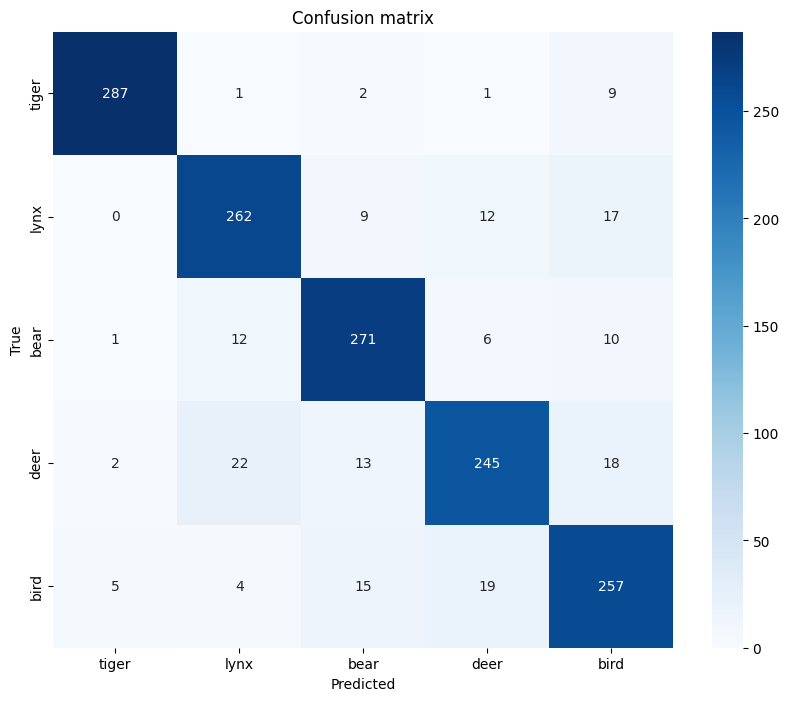

In [26]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')
confusion_matrix_path = media_dir + '/confusion_matrix.png'
plt.savefig(confusion_matrix_path, dpi=300, bbox_inches='tight')
plt.show()